## MIT-BIH Arrhythmia Dataset

### Dataset Description

- The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. 
- Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

In [1]:
import os    

# Ignore the line below. The system I used here had an AMD 520 GPU. 
# PlaidML was used to perform the tensor calculations
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Import Dependencies

In [2]:
import math
import random
import itertools
import numpy as np
np. random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import label_ranking_average_precision_score 
from sklearn.metrics import label_ranking_loss 
from sklearn.metrics import coverage_error
from sklearn.utils import shuffle
from scipy.signal import resample
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Input 
from keras.layers import Dense 
from keras.layers import Conv1D 
from keras.layers import MaxPooling1D 
from keras.layers import Softmax 
from keras.layers import Add
from keras.layers import Flatten 
from keras.layers import Activation
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using plaidml.keras.backend backend.


### Read the Data

In [3]:
df = pd.read_csv("Dataset/mitbih_train.csv", header = None)
df2 = pd.read_csv("Dataset/mitbih_test.csv", header = None)
df = pd.concat([df, df2], axis = 0)

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [5]:
df2

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


In [8]:
df[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

In [9]:
M = df.values
X = M[:, : - 1]
y = M[:, -1].astype(int)

In [10]:
del df
del df2
del M

In [11]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

### Plot One Heartbeat for Every Category

The dataset focuses primarily on the following features.
-	The feature ‘N’ is classified as Normal. 
-	The feature ‘S’ is classified as Supraventricular Ectopic Beat
-	The feature ‘V’ is classified as Ventricular Ectopic Beat
-	The feature ‘F’ is classified as Fusion Beat
-	The feature ‘Q’ is classified as Unknown Beat

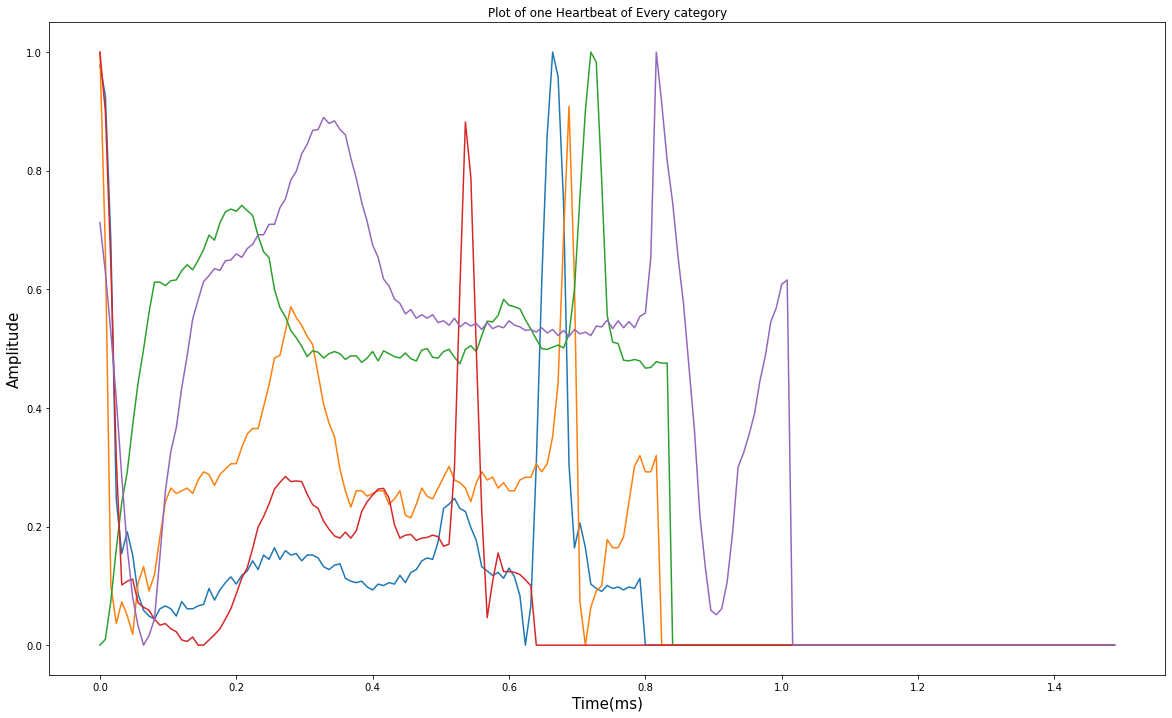

In [12]:
x = np.arange(0, 187) * 8 / 1000

plt.figure(figsize = (20, 12))
plt.plot(x, X[C0, :][0], label = "Cat.N")
plt.plot(x, X[C1, :][0], label = "Cat.S")
plt.plot(x, X[C2, :][0], label = "Cat.v")
plt.plot(x, X[C3, :][0], label = "Cat.F")
plt.plot(x, X[C4, :][0], label = "Cat.Q")
plt.legend
plt.title("Plot of one Heartbeat of Every category")
plt.xlabel("Time(ms)", fontsize = 15)
plt.ylabel("Amplitude", fontsize = 15)
plt.show()

### Data Pre-processing

In [13]:
def stretch(x):
    l = int(187 * (1 + (random.random() - 0.5) / 3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

In [14]:
def amplify(x):
    alpha = (random.random() - 0.5)
    factor = -alpha * x + (1 + alpha)
    return x * factor

In [15]:
def augment(x):
    result = np.zeros(shape = (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

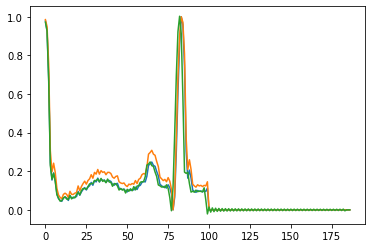

In [16]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [17]:
result = np.apply_along_axis(augment, axis = 1, arr = X[C3]).reshape(-1, 187)
classe = np.ones(shape = (result.shape[0], ) , dtype = int) * 3
X = np.vstack([X, result])
y = np.hstack([y, classe])

In [18]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [19]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis = 0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis = 0)

X_train, y_train = shuffle(X_train, y_train, random_state = 0)
X_test, y_test = shuffle(X_test, y_test, random_state = 0)

del X
del y

In [20]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [21]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150,)
X_test (4000, 187, 1)
y_test (4000,)


In [22]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))

In [23]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


In [24]:
n_obs, feature, depth = X_train.shape
batch_size = 500

### Model

In [25]:
K.clear_session()

inp = Input(shape = (feature, depth))
C = Conv1D(filters = 64, kernel_size = 5, strides = 1)(inp)

C11 = Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same')(C)
A11 = Activation("tanh")(C11)
C12 = Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same')(A11)
S11 = Add()([C12, C])
A12 = Activation("tanh")(S11)
M11 = MaxPooling1D(pool_size = 5, strides = 2)(A12)


C21 = Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same')(M11)
A21 = Activation("tanh")(C21)
C22 = Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("tanh")(S11)
M21 = MaxPooling1D(pool_size = 5, strides = 2)(A22)


C31 = Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same')(M21)
A31 = Activation("tanh")(C31)
C32 = Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("tanh")(S31)
M31 = MaxPooling1D(pool_size = 5, strides = 2)(A32)


C41 = Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same')(M31)
A41 = Activation("tanh")(C41)
C42 = Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("tanh")(S41)
M41 = MaxPooling1D(pool_size = 5, strides = 2)(A42)


C51 = Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same')(M41)
A51 = Activation("tanh")(C51)
C52 = Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("tanh")(S51)
M51 = MaxPooling1D(pool_size = 5, strides = 2)(A52)

F1 = Flatten()(M51)

D1 = Dense(2048)(F1)
A6 = Activation("tanh")(D1)
D2 = Dense(1024)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs = inp, outputs = A7)

model.summary()

INFO:plaidml:Opening device "opencl_amd_hainan.0"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 64)      384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 64)      20544       conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 64)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

### Save Weights

In [26]:
checkpoint = ModelCheckpoint("heartnet_AMD.h5", monitor = "val_acc", verbose = 1, save_best_only = True, mode = "auto")

In [27]:
callbacks = [checkpoint]

In [28]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [29]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

### Start Training

In [30]:
history = model.fit(X_train, y_train, 
                    epochs = 35, 
                    batch_size = batch_size, 
                    verbose = 1, 
                    validation_data = (X_test, y_test), 
                    callbacks = callbacks)

Train on 109150 samples, validate on 4000 samples
Epoch 1/35
109150/109150 [==============================] - 143s 1ms/step - loss: 0.4014 - acc: 0.8894 - val_loss: 0.7712 - val_acc: 0.7185

Epoch 00001: val_acc improved from -inf to 0.71850, saving model to heartnet_AMD.h5
Epoch 2/35
109150/109150 [==============================] - 93s 852us/step - loss: 0.2292 - acc: 0.9359 - val_loss: 0.6633 - val_acc: 0.8018

Epoch 00002: val_acc improved from 0.71850 to 0.80175, saving model to heartnet_AMD.h5
Epoch 3/35
109150/109150 [==============================] - 93s 855us/step - loss: 0.1507 - acc: 0.9575 - val_loss: 0.5827 - val_acc: 0.8008

Epoch 00003: val_acc did not improve from 0.80175
Epoch 4/35
109150/109150 [==============================] - 94s 864us/step - loss: 0.1415 - acc: 0.9606 - val_loss: 0.5858 - val_acc: 0.8235

Epoch 00004: val_acc improved from 0.80175 to 0.82350, saving model to heartnet_AMD.h5
Epoch 5/35
109150/109150 [==============================] - 94s 865us/step 

Text(0, 0.5, 'Accuracy')

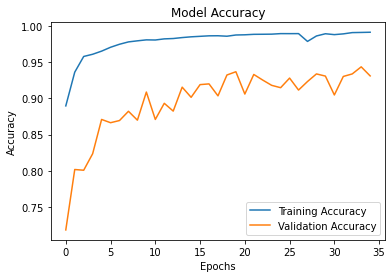

In [31]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

plt.legend(['Training Accuracy', 'Validation Accuracy'], loc = "lower right")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

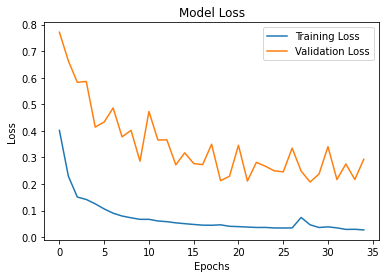

In [32]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.legend(['Training Loss', 'Validation Loss'], loc = "upper right")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

### Evaluate the Model

In [35]:
y_pred = model.predict(X_test, batch_size = 1000)

In [36]:
print(classification_report(y_test.argmax(axis = 1), y_pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88       800
           1       1.00      0.82      0.90       800
           2       0.93      0.94      0.94       800
           3       0.99      0.90      0.94       800
           4       0.99      0.99      0.99       800

    accuracy                           0.93      4000
   macro avg       0.94      0.93      0.93      4000
weighted avg       0.94      0.93      0.93      4000



In [37]:
print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test.todense(), y_pred)))
print("Coverage_error : {:.3f}".format(coverage_error(y_test.todense(), y_pred)))

ranking-based average precision : 0.963
Ranking loss : 0.021
Coverage_error : 1.086


### Plot Confusion Matrix

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
np.set_printoptions(precision = 2)

Confusion matrix, without normalization


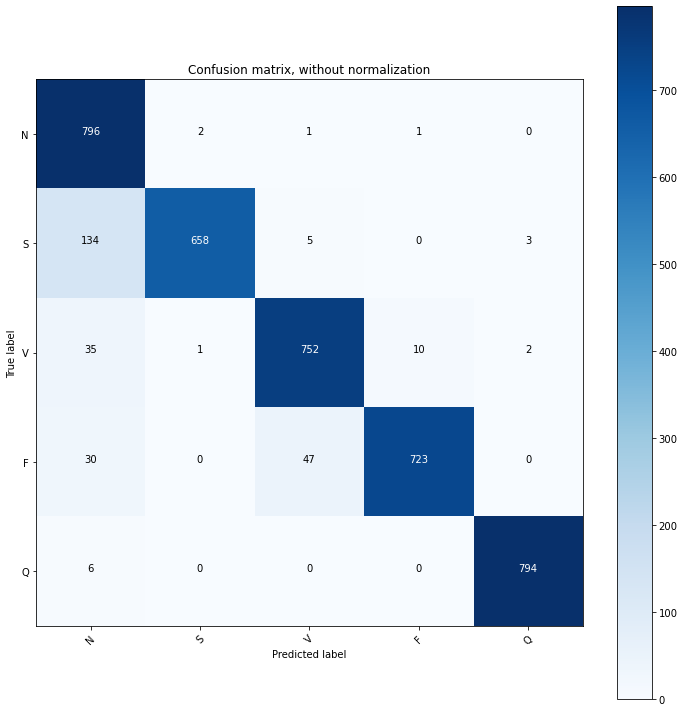

In [40]:
# Plot non-normalized confusion matrix
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes = ['N', 'S', 'V', 'F', 'Q'],
                      title = 'Confusion matrix, without normalization')
plt.show()